In [1]:
!pip install geopandas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from collections import Counter

In [2]:
data = pd.read_excel('saas.xlsx', engine='openpyxl')

# Preprocessing
data['Created Date'] = pd.to_datetime(data['Created Date'])
data['Week'] = data['Created Date'].dt.isocalendar().week
data['Year'] = data['Created Date'].dt.year


In [3]:
data['Revenue'] = data['Total']

In [4]:
weekly_revenue = data.groupby(['Year', 'Week'])['Revenue'].sum().reset_index()
weekly_revenue['Week_Label'] = weekly_revenue['Year'].astype(str) + "-W" + weekly_revenue['Week'].astype(str)

In [5]:
data['Size'] = data['Product'].str.extract(r'-\s*([SMLX]+)-')[0]
data['Category'] = data['Product'].str.extract(r'-\s*[SMLX]+-([a-z]+)')[0]

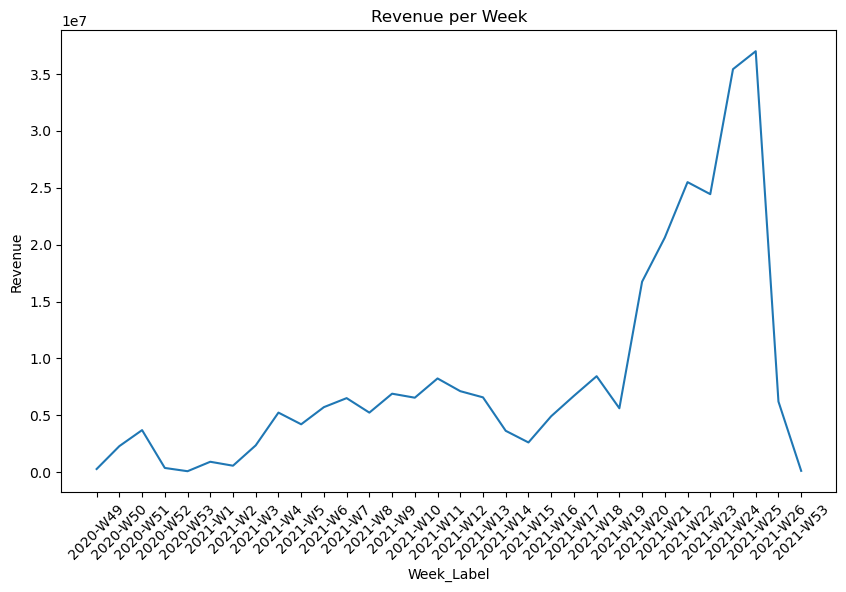

In [6]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=weekly_revenue, x='Week_Label', y='Revenue')
plt.xticks(rotation=45)
plt.title("Revenue per Week")
plt.show()

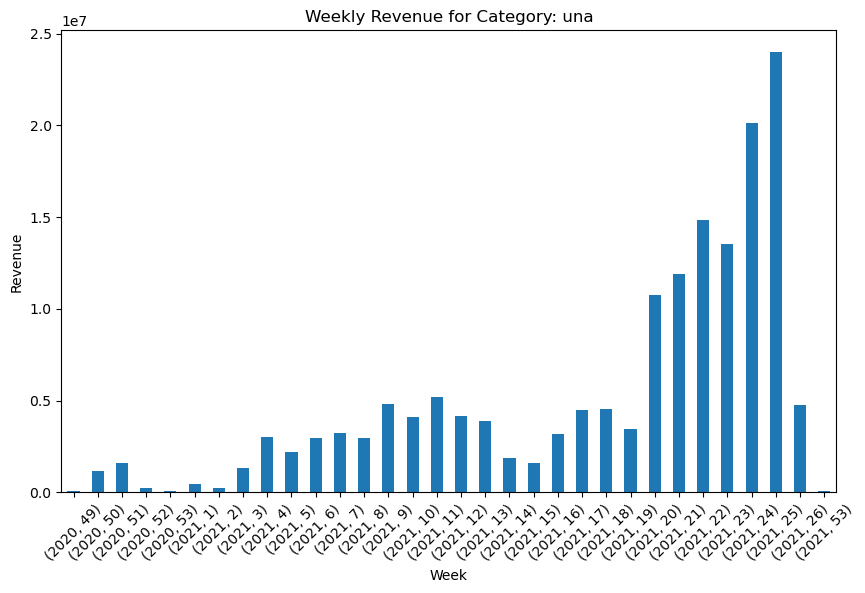

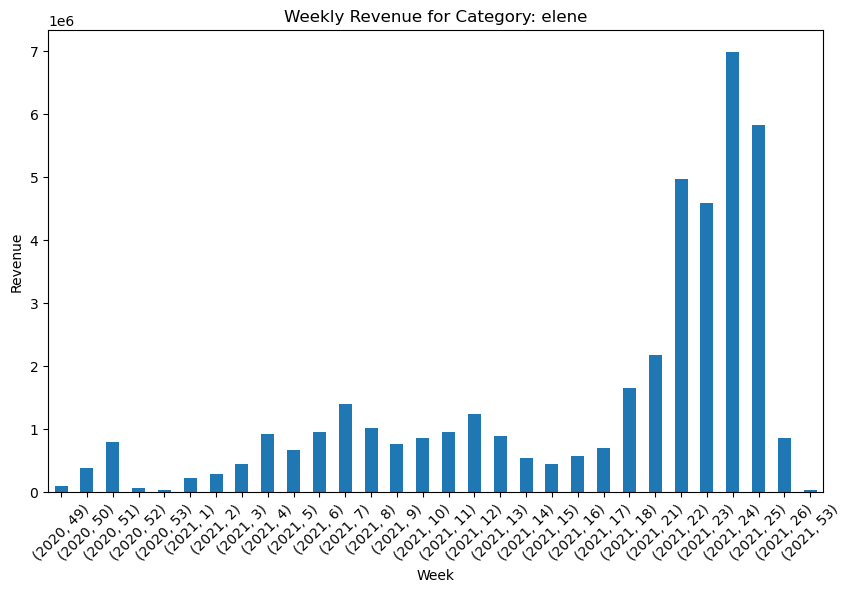

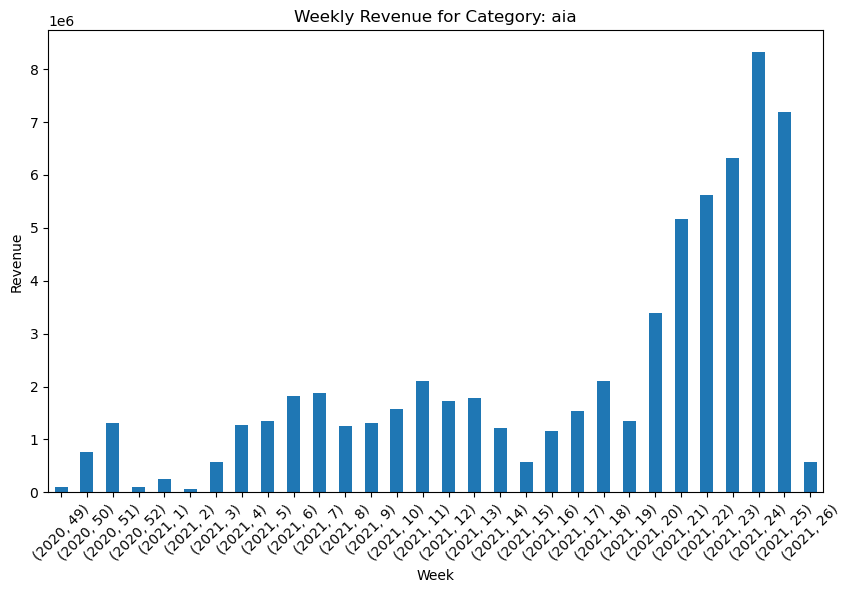

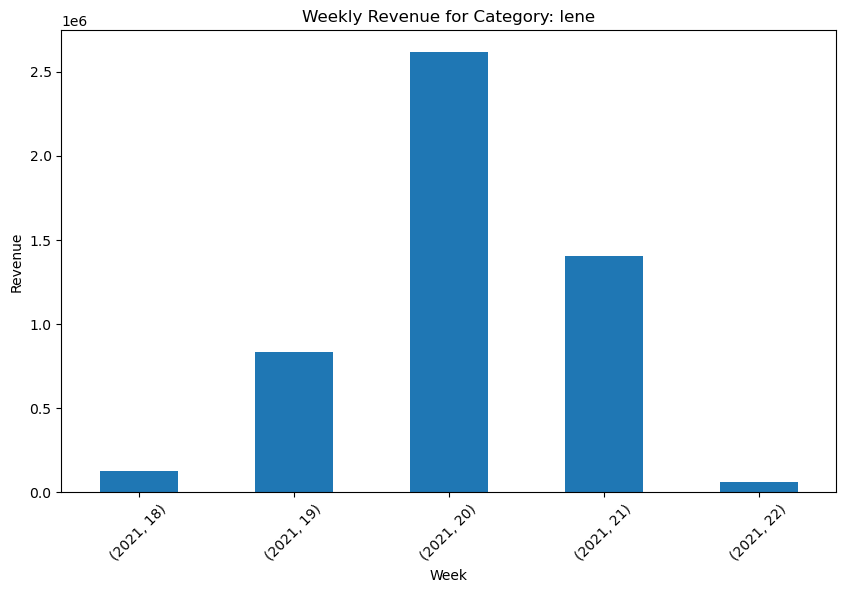

In [7]:
categories = data['Category'].unique()
for category in categories:
    category_data = data[data['Category'] == category]
    weekly_category_revenue = category_data.groupby(['Year', 'Week'])['Revenue'].sum()
    weekly_category_revenue.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Weekly Revenue for Category: {category}')
    plt.ylabel('Revenue')
    plt.xlabel('Week')
    plt.xticks(rotation=45)
    plt.show()

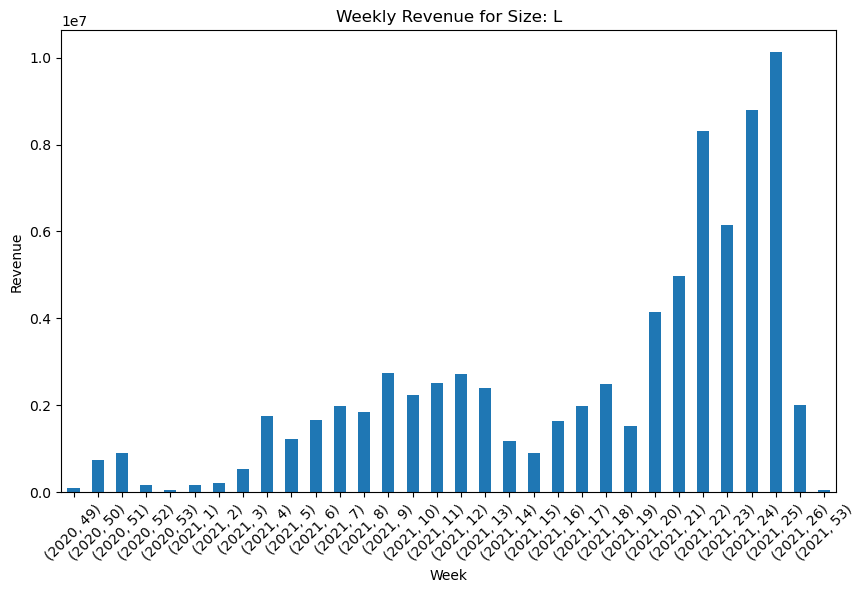

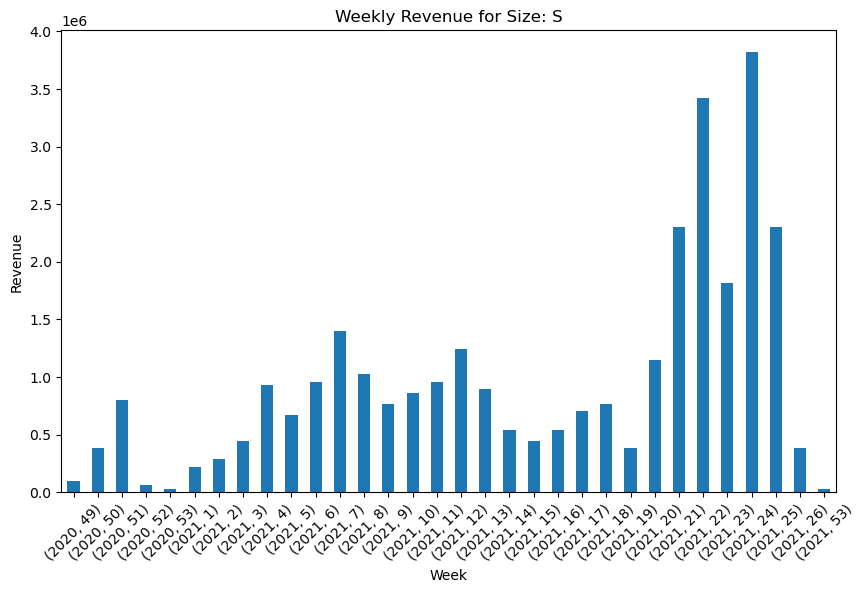

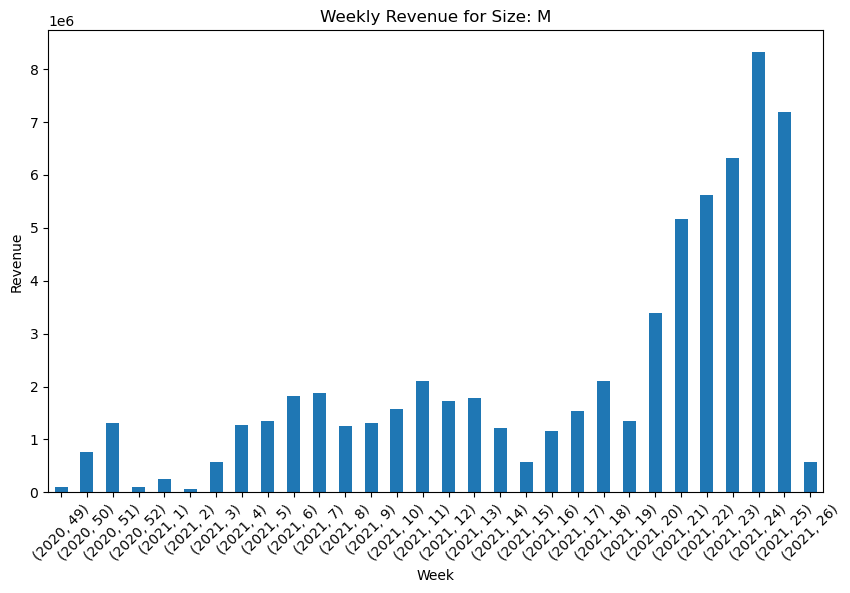

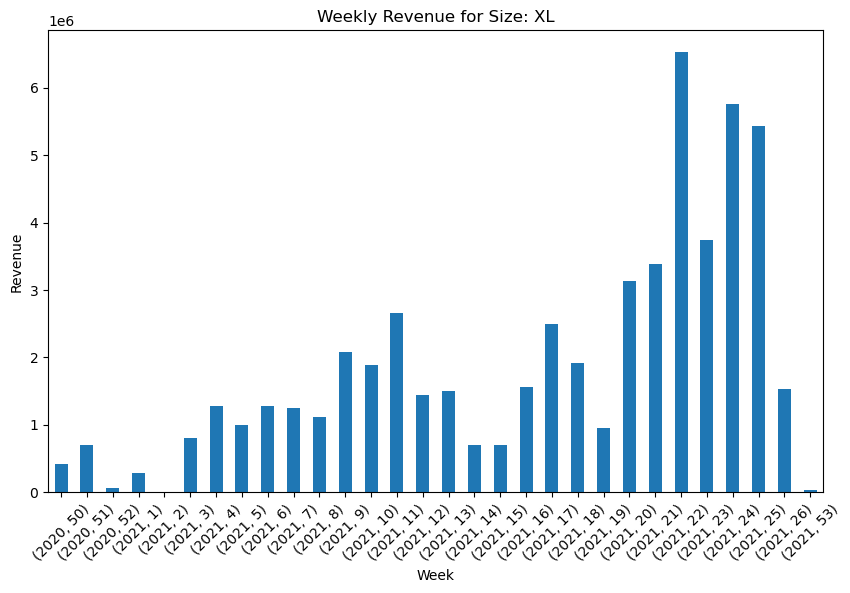

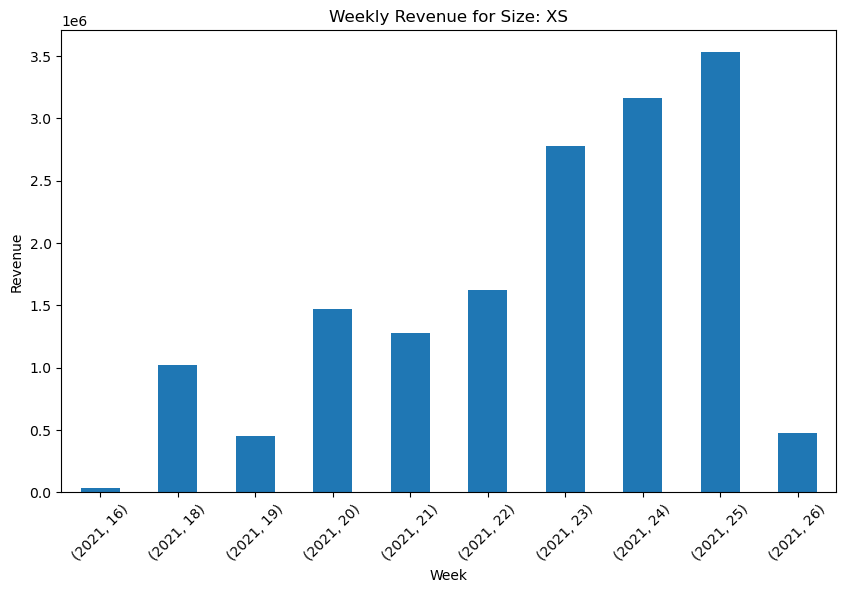

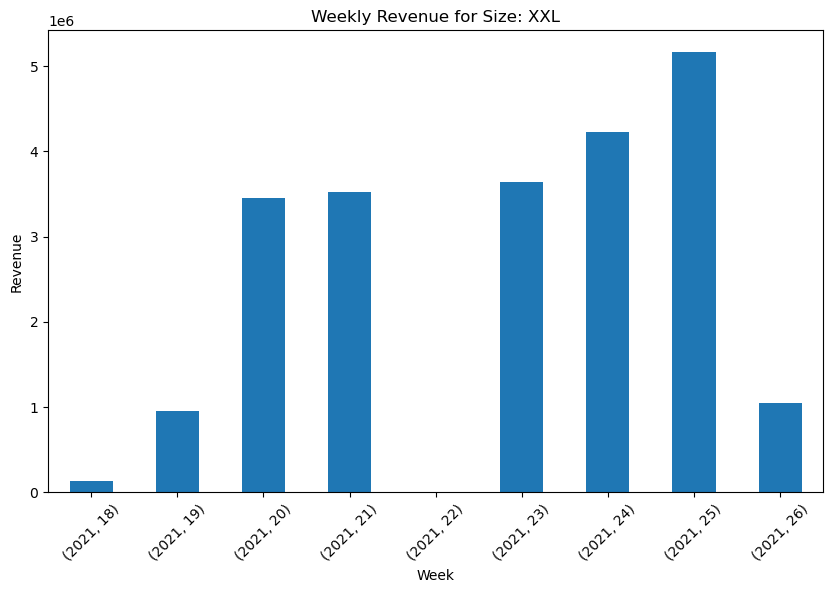

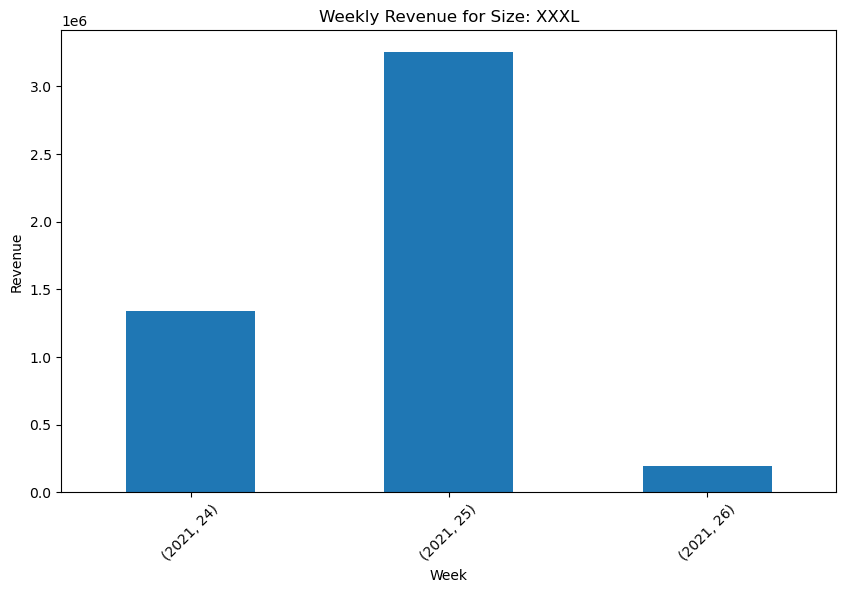

In [8]:
sizes = data['Size'].unique()
for size in sizes:
    size_data = data[data['Size'] == size]
    weekly_size_revenue = size_data.groupby(['Year', 'Week'])['Revenue'].sum()
    weekly_size_revenue.plot(kind='bar', figsize=(10, 6))
    plt.title(f'Weekly Revenue for Size: {size}')
    plt.ylabel('Revenue')
    plt.xlabel('Week')
    plt.xticks(rotation=45)
    plt.show()

In [29]:
import pandas as pd
import plotly.graph_objs as go
import re

# Step 1: Read the Excel file
df = pd.read_excel('saas.xlsx')

# Function to clean zip codes
def clean_zipcode(zipcode):
    # Convert to string, remove any non-digit characters
    cleaned = re.sub(r'\D', '', str(zipcode))
    # Ensure 6 digits, zero-pad if needed
    return cleaned.zfill(6)

# Clean zip codes
df['Billing Zip'] = df['Billing Zip'].apply(clean_zipcode)
df['Shipping Zip'] = df['Shipping Zip'].apply(clean_zipcode)

# Step 2: Get zip code frequencies
billing_zip_counts = df['Billing Zip'].value_counts().reset_index()
billing_zip_counts.columns = ['Zip', 'Billing_Count']
shipping_zip_counts = df['Shipping Zip'].value_counts().reset_index()
shipping_zip_counts.columns = ['Zip', 'Shipping_Count']

# Step 3: Load and clean coordinate data
zip_coordinates = pd.read_csv('pincodes.csv')
zip_coordinates['Zip'] = zip_coordinates['Zip'].apply(clean_zipcode)

# Remove duplicates from coordinates to ensure unique zip codes
zip_coordinates = zip_coordinates.drop_duplicates(subset=['Zip'])

# Merge data with coordinates
billing_data = pd.merge(billing_zip_counts, zip_coordinates, on='Zip', how='inner')
shipping_data = pd.merge(shipping_zip_counts, zip_coordinates, on='Zip', how='inner')

# Create the map
fig = go.Figure()

# Function to add zip code trace with precise sizing
def add_zipcode_trace(data, color, name):
    if not data.empty:
        # Calculate size based on count, but keep it more controlled
        max_size = 15  # Maximum bubble size
        min_size = 3   # Minimum bubble size
        
        # Normalize size with logarithmic scaling
        import numpy as np
        size_data = np.log1p(data[f'{name}_Count'])
        normalized_sizes = (size_data - size_data.min()) / (size_data.max() - size_data.min())
        bubble_sizes = normalized_sizes * (max_size - min_size) + min_size

        fig.add_trace(go.Scattergeo(
            lon=data['Long'],
            lat=data['Lat'],
            text=data.apply(lambda row: f"Zip: {row['Zip']}<br>{name} Count: {row[f'{name}_Count']}", axis=1),
            marker=dict(
                size=bubble_sizes,
                color=color,
                opacity=0.7,
                line_color='dark' + color,
                line_width=1
            ),
            name=f'{name} Zip Codes',
            hoverinfo='text'
        ))

# Add traces
add_zipcode_trace(billing_data, 'green', 'Billing')
add_zipcode_trace(shipping_data, 'blue', 'Shipping')

# Update layout for a more focused India map
fig.update_layout(
    title='Billing and Shipping Zip Code Distribution in India',
    geo=dict(
        scope='asia',
        showland=True,
        landcolor='rgb(243, 243, 243)',
        countrycolor='rgb(204, 204, 204)',
        coastlinecolor='rgb(204, 204, 204)',
        projection_type='mercator',
        # Tighter longitude and latitude ranges to focus on India
        lonaxis=dict(
            range=[72, 88],  # Narrower longitude range
            dtick=2
        ),
        lataxis=dict(
            range=[8, 38],   # Narrower latitude range
            dtick=2
        )
    ),
    showlegend=True,
    height=1200,
    width=1200
)

# Save the figure
fig.write_html("india_zipcode_distribution.html")

# Print some statistics
print("Billing Zip Codes:")
print("Total unique zips:", len(billing_zip_counts))
print("Matched zips:", len(billing_data))
print("\nShipping Zip Codes:")
print("Total unique zips:", len(shipping_zip_counts))
print("Matched zips:", len(shipping_data))

# Show the plot (in notebook or interactive environment)
fig.show()

Billing Zip Codes:
Total unique zips: 1171
Matched zips: 1148

Shipping Zip Codes:
Total unique zips: 1172
Matched zips: 1150
